In [83]:
import pandas as pd
def solution_data_normalization(u,X,t):
    data_dict={
        "u":u,
        "x":X[0],
        "y":X[1],
        "z":X[2],
        "t":t if t!=None else [None for _ in X[0]]
    }
    return pd.DataFrame(data_dict)

def darcy_2D_solution_data_normalization(P,U_x,U_y,X,t):
    data_dict={
        "P":P,
        "U_x":U_x,
        "U_y":U_y,
        "x":X[0],
        "y":X[1],
        "z":X[2],
        "t":t if t!=None else [None for _ in X[0]]
    }
    return pd.DataFrame(data_dict)

def darcy_3D_solution_data_normalization(P,U_x,U_y,U_z,X,t):
    data_dict={
        "P":P,
        "U_x":U_x,
        "U_y":U_y,
        "U_y":U_z,
        "x":X[0],
        "y":X[1],
        "z":X[2],
        "t":t if t!=None else [None for _ in X[0]]
    }
    return pd.DataFrame(data_dict)

## Darcy 3D

Bottom
$$z=0 \ \cap  \in \partial \Omega$$
top
$$z=1 \ \cap  \in \partial \Omega$$
wall
$$x=0 \ \cap x=1 \ \cap y=0 \ \cap y=1  \in \partial \Omega$$

$$ L()=\int C_1 n \cdot v ds_1 +\int C_2 n \cdot v ds_2 $$
$$ a()=\int (u \cdot v - \nabla v p - \nabla u q) dx $$

In [179]:
try:
    from petsc4py import PETSc

    import dolfinx

    if not dolfinx.has_petsc:
        print("This demo requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This demo requires petsc4py.")
    exit(0)

from mpi4py import MPI

import numpy as np

from basix.ufl import element, mixed_element
from dolfinx import default_real_type, fem, io, mesh
from dolfinx.fem.petsc import LinearProblem
from ufl import Measure, SpatialCoordinate, TestFunctions, TrialFunctions, div, exp, inner

nsteps=2
msh = mesh.create_unit_cube(MPI.COMM_WORLD, nsteps, nsteps, nsteps, mesh.CellType.hexahedron)

k = 2
Q_el = element("BDMCF", msh.basix_cell(), k) # Flux
P_el = element("DG", msh.basix_cell(), k - 1) # Pressure
V_el = mixed_element([Q_el, P_el])
V = fem.functionspace(msh, V_el)

(sigma, u) = TrialFunctions(V)
(tau, v) = TestFunctions(V)

x = SpatialCoordinate(msh)
f = 0.000000001 * exp(-((x[0] - 0.5) * (x[0] - 0.5) + (x[1] - 0.5) * (x[1] - 0.5) + (x[2] - 0.5) * (x[2] - 0.5)) / 0.02)
#f=0.00001

dx = Measure("dx", msh)
a = inner(sigma, tau) * dx - inner(u, div(tau)) * dx + inner(div(sigma), v) * dx
L = -f*v * dx

# Get subspace of V
V0 = V.sub(0)

fdim = msh.topology.dim - 1
facets_top = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 1.0))
Q, _ = V0.collapse()
dofs_top = fem.locate_dofs_topological((V0, Q), fdim, facets_top)


def f1(x):
    values = np.zeros((3, x.shape[1]))
    #values[1, :] = np.sin(5 * x[0])
    values[1, :] = 1
    return values


f_h1 = fem.Function(Q)
f_h1.interpolate(f1)
bc_top = fem.dirichletbc(f_h1, dofs_top, V0)


facets_bottom = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 0.0))
dofs_bottom = fem.locate_dofs_topological((V0, Q), fdim, facets_bottom)


def f2(x):
    values = np.zeros((3, x.shape[1]))
    #values[1, :] =-np.sin(5 * x[0])
    values[1, :] =-1
    return values


f_h2 = fem.Function(Q)
f_h2.interpolate(f2)
bc_bottom = fem.dirichletbc(f_h2, dofs_bottom, V0)


bcs = [bc_top, bc_bottom]

problem = LinearProblem(
    a,
    L,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "superlu_dist",
    },
)
try:
    w_h = problem.solve()
except PETSc.Error as e:  # type: ignore
    if e.ierr == 92:
        print("The required PETSc solver/preconditioner is not available. Exiting.")
        print(e)
        exit(0)
    else:
        raise e

sigma_h, u_h = w_h.split()


In [180]:
step=3
sols=[]
for i in range(msh.geometry.x.shape[0]//step):
    pp=msh.geometry.x[i*step:(i+1)*step]
    sols.append(sigma_h.collapse().eval(pp,np.arange(pp.shape[0])))
P=np.concatenate(sols,axis=0)
P

array([[ 1.75845170e+15, -3.97010859e-01, -1.47293960e+15],
       [-1.09043528e+03, -1.00000000e+00, -1.86754572e+04],
       [ 1.51369139e+04, -9.21114768e+02,  6.61444750e+04],
       [ 1.15401473e+04, -1.41725498e+04,  7.48543076e+14],
       [ 7.85591840e+04, -1.00000000e+00,  2.92287283e+04],
       [-4.82257676e+04, -1.04477307e+05, -3.12723839e+04],
       [-4.63030982e+14,  1.82207601e+03,  4.30067154e+04],
       [-1.33324857e+04,  7.52362947e+03,  1.71809754e+03],
       [-1.90256425e+05, -1.20856352e+05,  2.17084651e+05],
       [ 1.39625343e+15, -1.20271017e+04,  2.41465508e+13],
       [ 1.16319277e+03, -1.00000000e+00,  2.79163061e+03],
       [-5.91883835e+04, -9.62857170e+03,  1.34037512e+04],
       [-5.27535509e+15, -2.85512094e+14,  4.41881881e+15],
       [ 1.51173732e+04, -4.69555072e+04, -7.64447678e+04],
       [ 9.76659520e+03,  1.00000000e+00,  4.16320367e+03],
       [-4.87347637e+04,  2.85512094e+14,  1.09585854e+05],
       [ 6.95270451e+04, -9.99999992e-01

In [181]:
step=3

sols=[]
for i in range(msh.geometry.x.shape[0]//step):
    pp=msh.geometry.x[i*step:(i+1)*step]
    #print(u_h.collapse().eval(pp,np.arange(pp.shape[0])))
    sols.append(u_h.collapse().eval(pp,np.arange(pp.shape[0])))
U=np.concatenate(sols,axis=0)

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


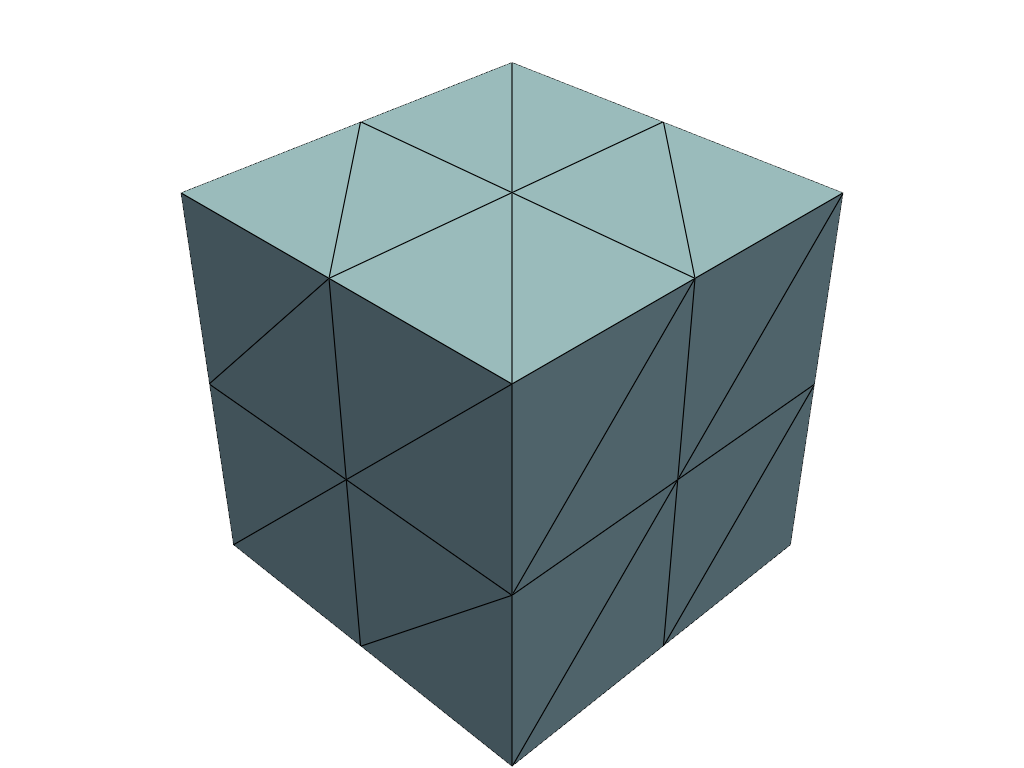

In [182]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=msh
pyvista.start_xvfb()
tdim = msh.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.isometric_view_interactive()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


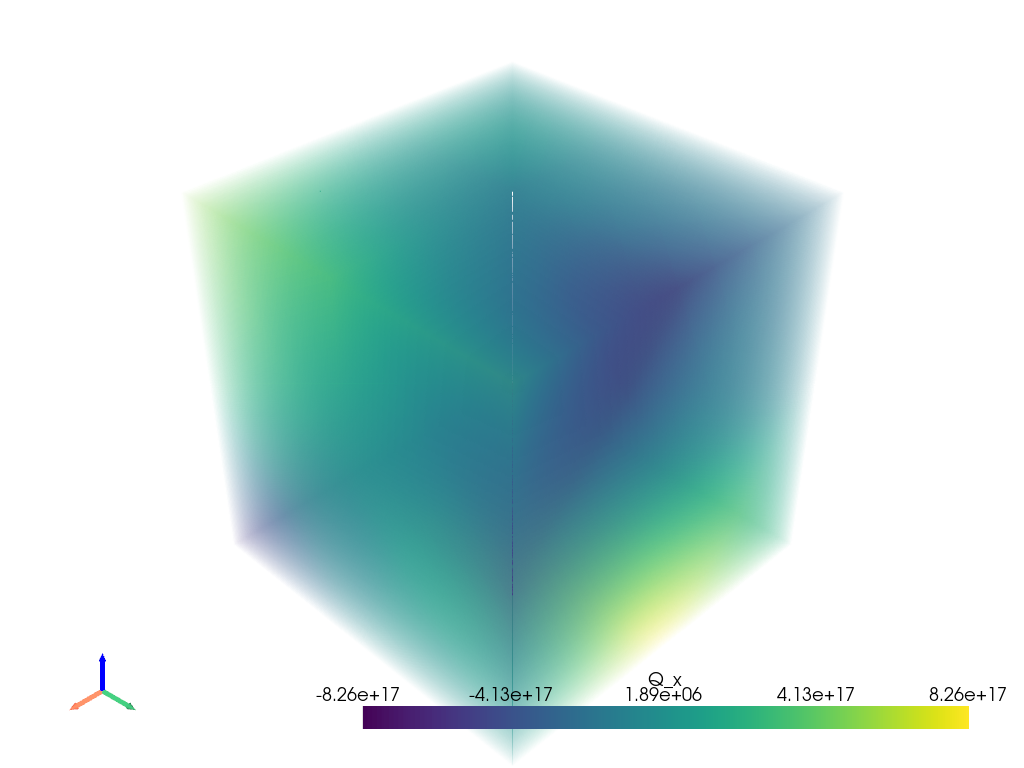

In [183]:
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.point_data["Q_x"] = U
u_grid.set_active_scalars("Q_x")
u_plotter = pyvista.Plotter()
#u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.add_volume(u_grid, opacity='foreground',opacity_unit_distance=0.3,multi_colors=True)
u_plotter.isometric_view_interactive()
_ = u_plotter.add_axes(line_width=5, labels_off=True)
if not pyvista.OFF_SCREEN:
    u_plotter.show()

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


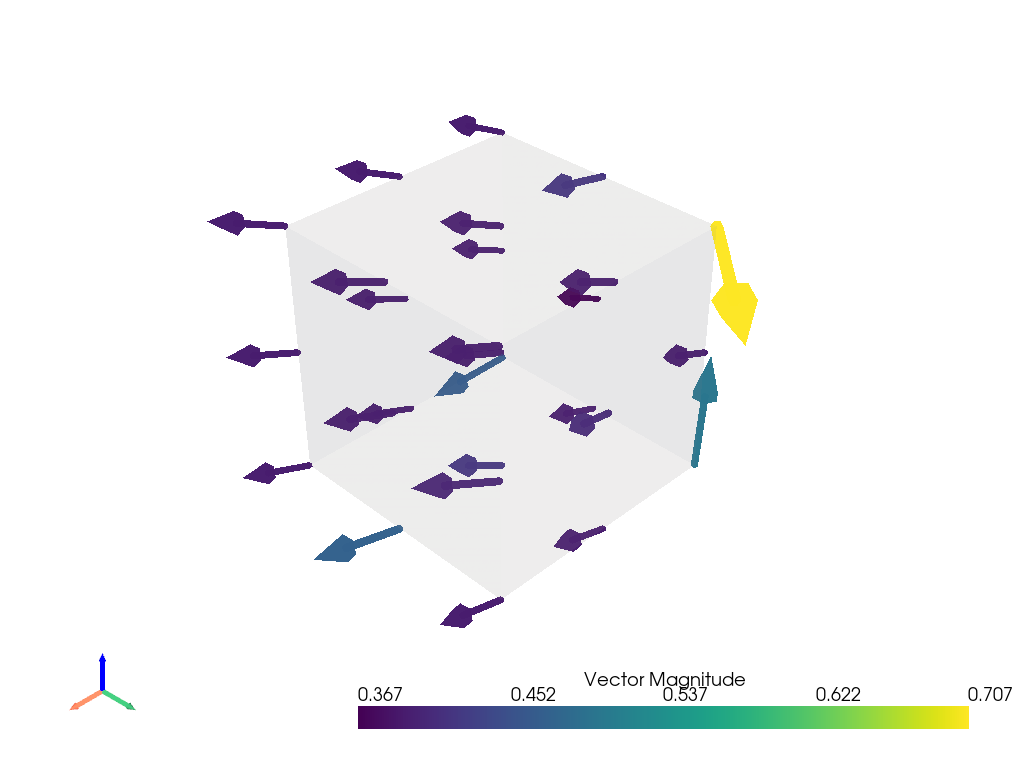

In [184]:
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid["P"] = ((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
u_grid.set_active_vectors("P")

p = pyvista.Plotter()
p.add_mesh(u_grid.arrows, lighting=False,opacity=0.9, scalar_bar_args={"title": "Vector Magnitude"})
p.add_mesh(u_grid, color="grey", ambient=0.6, opacity=0.1, show_edges=False)
_ = p.add_axes(line_width=5, labels_off=True)
p.isometric_view_interactive()

p.show()

In [85]:
dd=darcy_3D_solution_data_normalization(
    P=U[:,0],
    U_x=P[:,0],
    U_y=P[:,1],
    U_z=P[:,1],
    X=geometry.T,
    t=None
)

dd.to_csv("../Data/3D_darcy_mixed_formulation_eq_Dirichlet_BC.csv")

## Darcy 2D

In [185]:
try:
    from petsc4py import PETSc

    import dolfinx

    if not dolfinx.has_petsc:
        print("This demo requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This demo requires petsc4py.")
    exit(0)

from mpi4py import MPI

import numpy as np

from basix.ufl import element, mixed_element
from dolfinx import default_real_type, fem, io, mesh
from dolfinx.fem.petsc import LinearProblem
from ufl import Measure, SpatialCoordinate, TestFunctions, TrialFunctions, div, exp, inner

msh = mesh.create_unit_square(MPI.COMM_WORLD, 7, 7, mesh.CellType.quadrilateral)

k = 2
Q_el = element("BDMCF", msh.basix_cell(), k) # Flux
P_el = element("DG", msh.basix_cell(), k - 1) # Pressure
V_el = mixed_element([Q_el, P_el])
V = fem.functionspace(msh, V_el)

(sigma, u) = TrialFunctions(V)
(tau, v) = TestFunctions(V)

x = SpatialCoordinate(msh)
f = 1e+1 * exp(-((x[0] - 0.5) * (x[0] - 0.5) + (x[1] - 0.5) * (x[1] - 0.5)) / 0.02)
#f=0.00001

dx = Measure("dx", msh)
a = inner(sigma, tau) * dx - inner(u, div(tau)) * dx + inner(div(sigma), v) * dx
L = -f*v * dx

# Get subspace of V
V0 = V.sub(0)

fdim = msh.topology.dim - 1
facets_top = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 1.0))
Q, _ = V0.collapse()
dofs_top = fem.locate_dofs_topological((V0, Q), fdim, facets_top)


def f1(x):
    values = np.zeros((2, x.shape[1]))
    #values[1, :] = np.sin(5 * x[0])
    values[1, :] = 1
    return values


f_h1 = fem.Function(Q)
f_h1.interpolate(f1)
bc_top = fem.dirichletbc(f_h1, dofs_top, V0)


facets_bottom = mesh.locate_entities_boundary(msh, fdim, lambda x: np.isclose(x[1], 0.0))
dofs_bottom = fem.locate_dofs_topological((V0, Q), fdim, facets_bottom)


def f2(x):
    values = np.zeros((2, x.shape[1]))
    #values[1, :] =-np.sin(5 * x[0])
    values[1, :] =-1
    return values


f_h2 = fem.Function(Q)
f_h2.interpolate(f2)
bc_bottom = fem.dirichletbc(f_h2, dofs_bottom, V0)


bcs = [bc_top, bc_bottom]

problem = LinearProblem(
    a,
    L,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "superlu_dist",
    },
)
try:
    w_h = problem.solve()
except PETSc.Error as e:  # type: ignore
    if e.ierr == 92:
        print("The required PETSc solver/preconditioner is not available. Exiting.")
        print(e)
        exit(0)
    else:
        raise e

sigma_h, u_h = w_h.split()

with io.XDMFFile(msh.comm, "out_mixed_poisson/u.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(u_h)

RuntimeError: Function and Mesh dof layouts do not match. Maybe the Function needs to be interpolated?

In [188]:
step=2
sols=[]
for i in range(msh.geometry.x.shape[0]//step):
    pp=msh.geometry.x[i*step:(i+1)*step]
    sols.append(sigma_h.collapse().eval(pp,np.arange(pp.shape[0])))
P=np.concatenate(sols,axis=0)
#sigma_h.collapse().eval(msh.geometry.x[:4],np.arange(msh.geometry.x[:4].shape[0]))
#([[0,0,0]],[0])
#([0,0])

In [189]:
step=2
sols=[]
for i in range(msh.geometry.x.shape[0]//step):
    pp=msh.geometry.x[i*step:(i+1)*step]
    #print(u_h.collapse().eval(pp,np.arange(pp.shape[0])))
    sols.append(u_h.collapse().eval(pp,np.arange(pp.shape[0])))
U=np.concatenate(sols,axis=0)

static


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


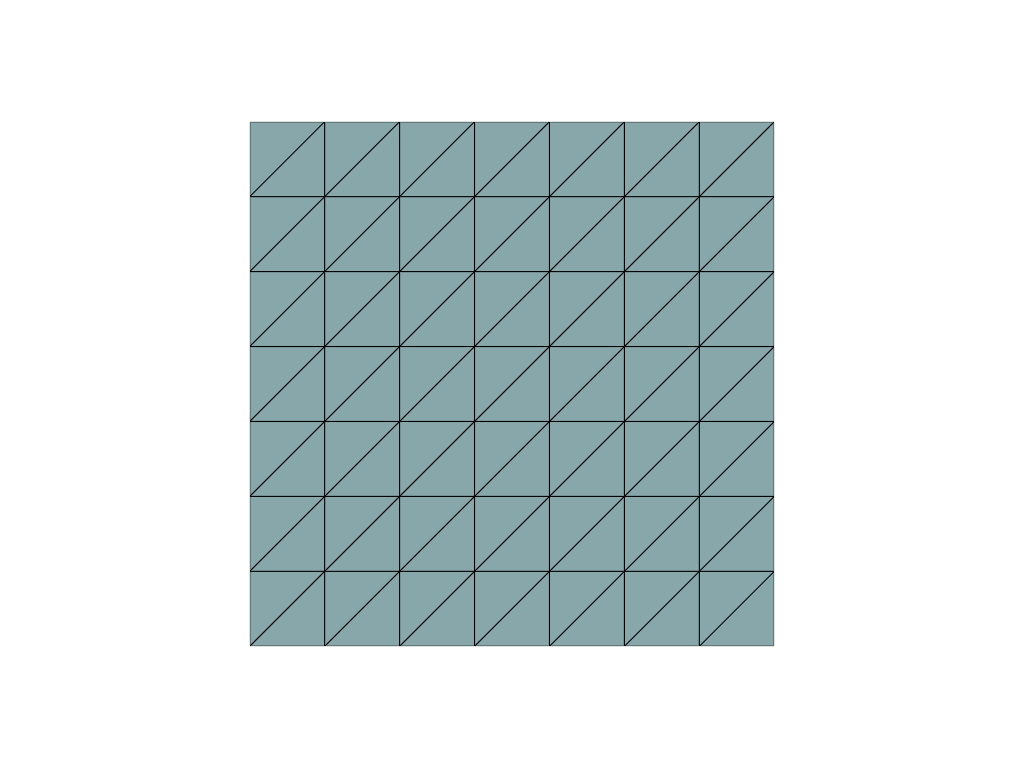

In [190]:
from dolfinx import plot
import pyvista
print(pyvista.global_theme.jupyter_backend)
domain=msh
pyvista.start_xvfb()
tdim = msh.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")



error: XDG_RUNTIME_DIR is invalid or not set in the environment.


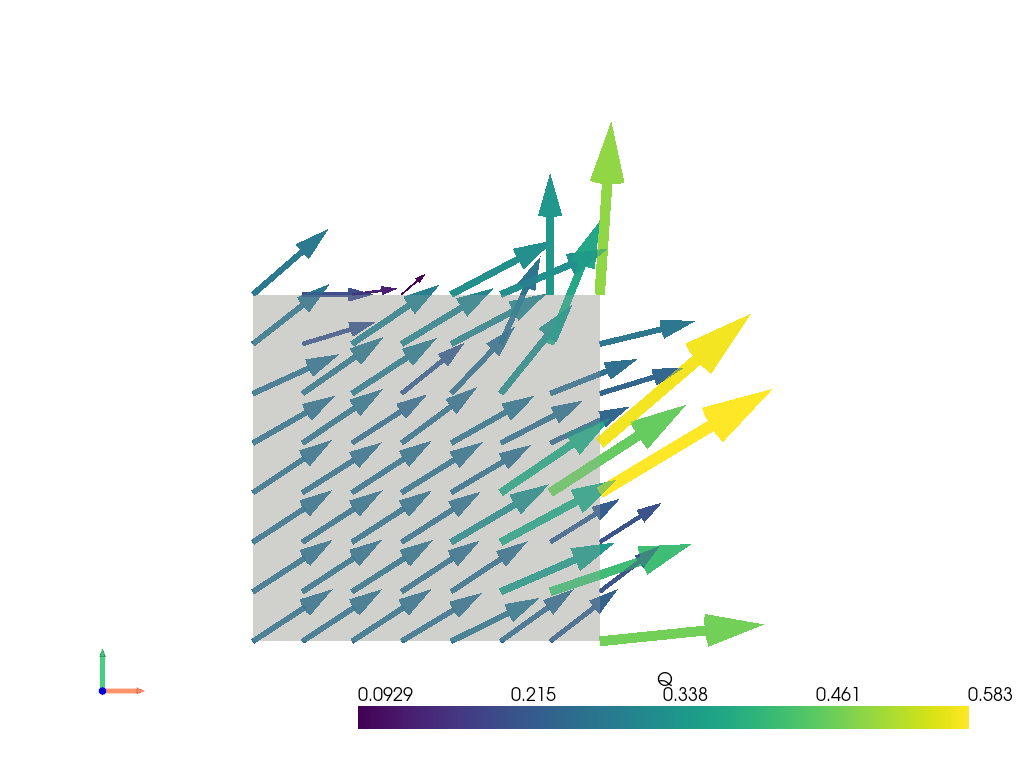

In [192]:
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
#P_=np.concatenate((P,np.ones((P.shape[0],1))),axis=1)
#u_grid["P"] = P_
P=((P-P.min(axis=0))/(P.max(axis=0)-P.min(axis=0)))*0.5
P=P
P_=np.concatenate((P,np.zeros((P.shape[0],1))),axis=1)
u_grid["P"]=P_
u_grid.set_active_vectors("P")

p = pyvista.Plotter()
p.add_mesh(u_grid.arrows, line_width=0.5,lighting=False,opacity=0.9, scalar_bar_args={"title": "Q"})
p.add_mesh(u_grid, color="grey", ambient=0.6, opacity=0.6, show_edges=False)
_ = p.add_axes(line_width=5, labels_off=True)
p.view_xy()

p.show()

In [178]:
P

array([[0.27372953, 0.29968076],
       [0.27192855, 0.3006126 ],
       [0.27244819, 0.29968076],
       [0.27224315, 0.29985686],
       [0.27158468, 0.29967071],
       [0.27156071, 0.30194598],
       [0.2718822 , 0.29968076],
       [0.267003  , 0.29896714],
       [0.27031143, 0.29524506],
       [0.27089077, 0.30862304],
       [0.27083293, 0.29637979],
       [0.26766046, 0.30283949],
       [0.27421699, 0.29794342],
       [0.25645388, 0.31767639],
       [0.2620295 , 0.2827027 ],
       [0.26845815, 0.30415481],
       [0.27139092, 0.29433236],
       [0.24433424, 0.31298745],
       [0.27577423, 0.29678572],
       [0.2389826 , 0.34837877],
       [0.25490947, 0.26572373],
       [0.27845801, 0.31957001],
       [0.26341421, 0.28723754],
       [0.21436533, 0.27923245],
       [0.2730847 , 0.29968076],
       [0.16853294, 0.29549402],
       [0.26568831, 0.24496534],
       [0.26895591, 0.41557652],
       [0.24317106, 0.26127511],
       [0.27618583, 0.29890391],
       [0.

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


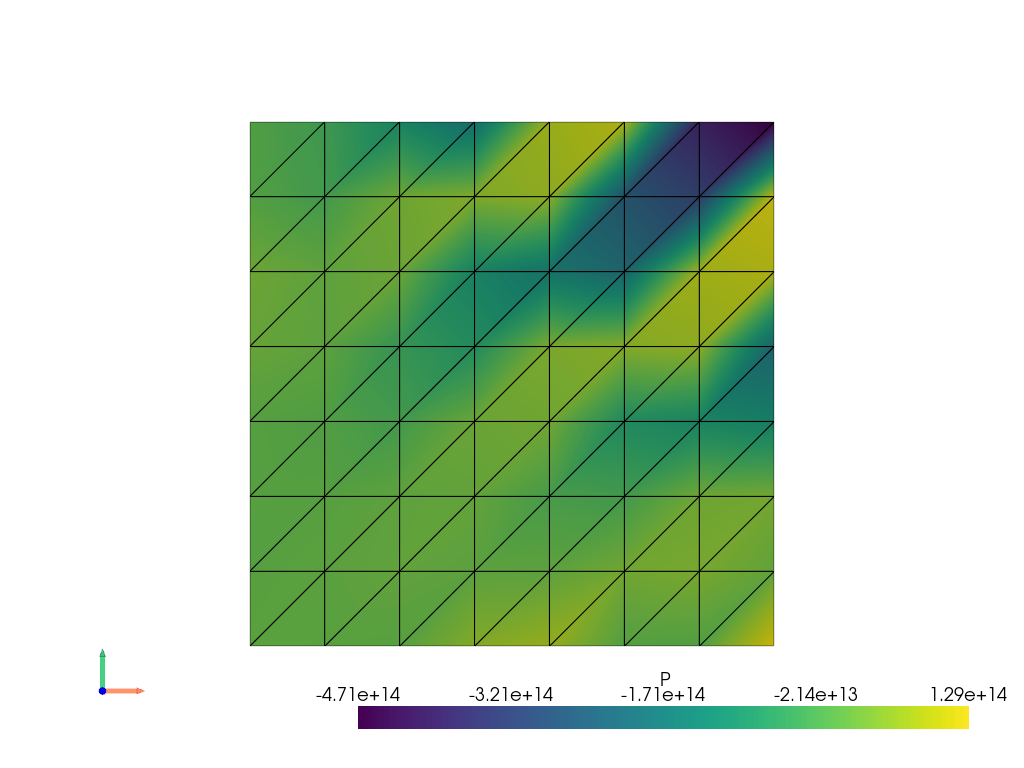

In [175]:
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.point_data["P"] = U
u_grid.set_active_scalars("P")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.add_axes(line_width=5, labels_off=True)
if not pyvista.OFF_SCREEN:
    u_plotter.show()

In [232]:
dd=darcy_2D_solution_data_normalization(
    P=U[:,0],
    U_x=P[:,0],
    U_y=P[:,1],
    X=geometry.T,
    t=None
)

dd.to_csv("../Data/2D_darcy_mixed_formulation_eq_Dirichlet_BC.csv")